In [1]:
import pandas as pd
import os
import time

from math import radians, cos, sin, asin, sqrt


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# found here https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
# Is correct, but quite slow

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [3]:
def fast_distance(lon1, lat1, lon2, lat2):
    R = 6371  # radius of the earth in km
    x = (lon2 - lon1) * cos( 0.5*(lat2+lat1) )
    y = lat2 - lat1
    d = R * sqrt( x*x + y*y ) # distance in km
    
    return d

In [4]:
def check_distance(row):    
    tolerance = 1    # measured in km
    distance = fast_distance(row.Lon, row.Lat, row.RealLon, row.RealLat)
    
    return (True if distance < tolerance else False)

In [5]:

def read_data(filename):

    df = pd.read_csv(filename, low_memory=False, header=None)
    df.columns = ["Timestamp", "LineID", "JourneyPatternID", "TimeFrame", 
                  "VehicleJourneyID", "Lon", "Lat", "VehicleID", "StopID", 
                  "AtStop", "HumanTime", "Day", "Hour", "JourneyGroup", "Runtime"]

    
    return df

In [6]:
def filter_distance(df, locations):
    locations = locations.rename(columns={'Lon': 'RealLon', 'Lat': 'RealLat'})
    
    df = pd.merge(df, locations, how='inner', on=['StopID'])
    df["ValidDistance"] = True
    df["ValidDistance"] = df.apply(check_distance, axis=1)
    
    df = df[df.ValidDistance == True]
    
    # Dropping irrelevant columns
    for column in ['RealLat', 'RealLon', 'ValidDistance']:
        df = df.drop(column, 1)
    
    return df

In [7]:
def main(read_directory, write_directory, location_csv):
    
    print("Reading locations")
    locations = pd.read_csv(location_csv)

    for read_file in os.listdir(read_directory):
        if read_file.endswith(".csv"):
            if os.path.isfile(write_directory + "/" + read_file):
                print(read_file, "exists")
            else:
                print("Reading", read_file, "from", read_directory)
                try:
                    df = read_data(read_directory + "/" + read_file)
                    df = filter_distance(df, locations)

                    with open(write_directory + "/" + read_file, 'w+') as f:
                        df.to_csv(f, header=False, index=False)
                except (ValueError, IndexError) as error:
                    print(error, "!")
                    print("Couldn't finish", read_file)
                    
                print("Finished", read_file)
                print()
    print("Finished main!")

In [8]:
read_directory = "bus_data/clean_data5"
write_directory = "bus_data/clean_location_data/"
location_csv = 'bus_data/stop_locations.csv'

main(read_directory, write_directory, location_csv)

Reading locations
Reading 1.csv from bus_data/clean_data5
Finished 1.csv

Reading 102.csv from bus_data/clean_data5
Finished 102.csv

Reading 104.csv from bus_data/clean_data5
Finished 104.csv

Reading 11.csv from bus_data/clean_data5
Finished 11.csv

Reading 111.csv from bus_data/clean_data5
Finished 111.csv

Reading 114.csv from bus_data/clean_data5
Finished 114.csv

Reading 116.csv from bus_data/clean_data5
Finished 116.csv

Reading 118.csv from bus_data/clean_data5
Finished 118.csv

Reading 120.csv from bus_data/clean_data5
Finished 120.csv

Reading 122.csv from bus_data/clean_data5
Finished 122.csv

Reading 123.csv from bus_data/clean_data5
Finished 123.csv

Reading 13.csv from bus_data/clean_data5
Finished 13.csv

Reading 130.csv from bus_data/clean_data5
Finished 130.csv

Reading 14.csv from bus_data/clean_data5
Finished 14.csv

Reading 140.csv from bus_data/clean_data5
Finished 140.csv

Reading 142.csv from bus_data/clean_data5
Finished 142.csv

Reading 145.csv from bus_data/cl

### --Rough work--

In [139]:
line = '220'
# df = read_data('bus_data/clean_data_rough/' + line + '.csv')
df = pd.read_csv('bus_data/clean_data_rough/' + line + '.csv', low_memory=False)
locations = pd.read_csv('bus_data/stop_locations.csv')

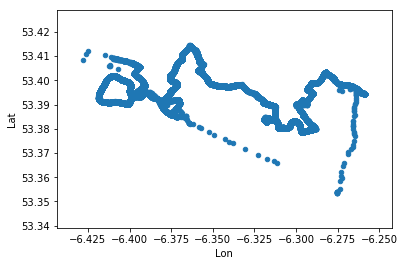

In [140]:
plotdf = df[["Lon", "Lat"]]
plotdf.plot.scatter(x="Lon", y="Lat")

In [141]:
df_0001 = df[df.JourneyPatternID == 1]

df_0001.StopID.unique().shape

(86,)

In [142]:
df = filter_distance(df, locations)


In [143]:
df_0001 = df[df.JourneyPatternID == 1]

df_0001.StopID.unique().shape

(81,)

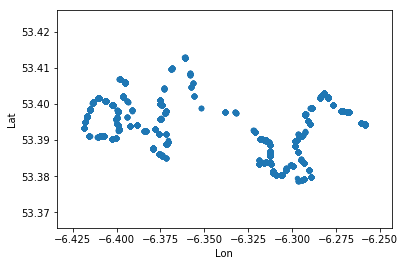

In [144]:
plotdf = df[["Lon", "Lat"]]
plotdf.plot.scatter(x="Lon", y="Lat")

In [28]:
# changing name of Lat and Lon so that they can be distinguished

locations = locations.rename(columns={'Lon': 'RealLon', 'Lat': 'RealLat'})

In [29]:
locations.tail()

,StopID,RealLat,RealLon
4714,7259,53.121085,-6.535927
4715,7256,53.129805,-6.527291
4716,7255,53.148724,-6.536721
4717,6087,53.446092,-6.132319
4718,3621,53.448382,-6.136781


In [33]:
df = pd.merge(df, locations, how='inner', on=['StopID'])

In [44]:
df.shape

(518286, 18)

In [58]:
def check_distance(row):    
    tolerance = 1    # measured in km
    distance = fast_distance(row.Lon, row.Lat, row.RealLon, row.RealLat)
    
    return (True if distance < tolerance else False)

df["ValidDistance"] = True
df["ValidDistance"] = df.apply(check_distance, axis=1)

In [59]:
df.ValidDistance.value_counts()

False    281240
True     237046
Name: ValidDistance, dtype: int64

In [60]:
trimmed_df = df[df.ValidDistance == True]

In [62]:
trimmed_df.head()

,Timestamp,LineID,JourneyPatternID,TimeFrame,VehicleJourneyID,Lon,Lat,VehicleID,StopID,AtStop,HumanTime,Day,Hour,JourneyGroup,Runtime,RealLat,RealLon,ValidDistance
1,1352182204000000,15,1,2012-11-06,5899,-6.151132,53.402328,33498,6318,0,2012-11-06 06:10:04,1,6,2012-11-065899,0,53.402314,-6.150992,True
16,1352192390000000,15,1,2012-11-06,5828,-6.150883,53.402351,33523,6318,1,2012-11-06 08:59:50,1,8,2012-11-065828,0,53.402314,-6.150992,True
17,1352192858000000,15,1,2012-11-06,5835,-6.150987,53.402309,33254,6318,1,2012-11-06 09:07:38,1,9,2012-11-065835,0,53.402314,-6.150992,True
18,1352193393000000,15,1,2012-11-06,5853,-6.150987,53.402309,33209,6318,1,2012-11-06 09:16:33,1,9,2012-11-065853,0,53.402314,-6.150992,True
19,1352194244000000,15,1,2012-11-06,5878,-6.151132,53.402328,33020,6318,0,2012-11-06 09:30:44,1,9,2012-11-065878,0,53.402314,-6.150992,True


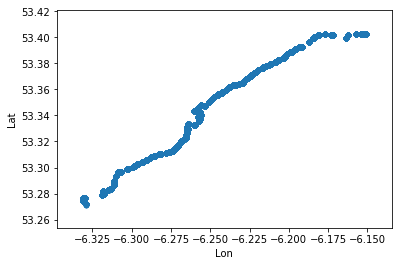

In [61]:
plotdf = trimmed_df[["Lon", "Lat"]]
plotdf.plot.scatter(x="Lon", y="Lat")